In [1]:
import torch
from torch.fft import fft, ifft, fftshift, ifftshift
from bounds import dct1, idct1, dct2, idct2, dst1, idst1, dst2, idst2, pad, ensure_shape
import matplotlib.pyplot as plt
import math

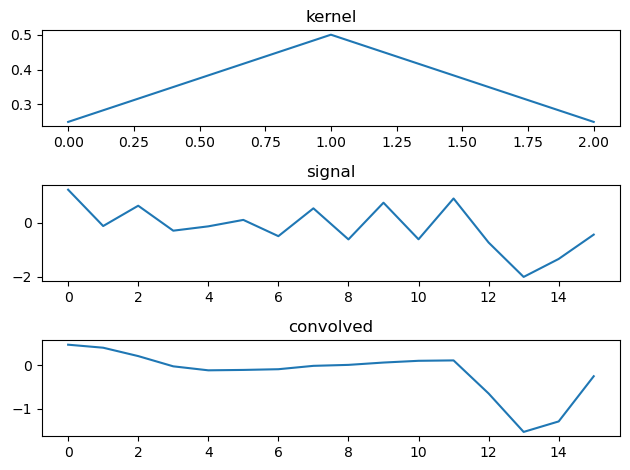

In [2]:
def conv1d(x, kernel, bound='dft'):
    padsize = (len(k)-1)//2
    return torch.nn.functional.conv1d(
        pad(x, [padsize], mode=bound, side='both')[None, None],
        kernel[None, None]
    )[0, 0]


k = torch.as_tensor([0.25, 0.5, 0.25], dtype=torch.double)

N = 16
i = torch.arange(N)
x = torch.randn([N], dtype=torch.double)
y = conv1d(x, k, bound='dft')

plt.subplot(3, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(3, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(3, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.tight_layout()
plt.show()

tensor([-5.5511e-17,  1.1102e-16,  1.1102e-16,  2.7756e-17,  9.7145e-17,
        -5.5511e-17,  2.7756e-17, -1.3878e-17,  5.5511e-17,  0.0000e+00,
         0.0000e+00,  5.5511e-17, -1.1102e-16, -2.2204e-16,  0.0000e+00,
        -1.1102e-16], dtype=torch.float64)


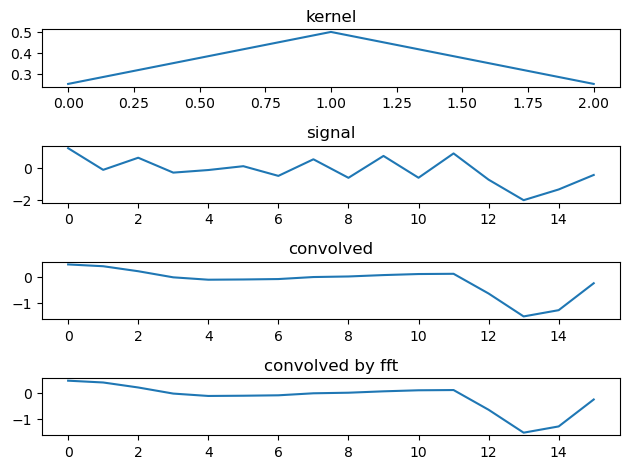

In [3]:
def convdft(x, kernel):
    kernel = ifftshift(ensure_shape(kernel, x.shape, side='both', ceil=True))
    return ifft(fft(x) * fft(kernel)).real


y = conv1d(x, k, bound='dft')
z = convdft(x, k)
print(y-z)

plt.subplot(4, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(4, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(4, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.subplot(4, 1, 4)
plt.plot(z)
plt.title('convolved by fft')
plt.tight_layout()
plt.show()

tensor([ 0.0000e+00, -5.5511e-17,  2.7756e-17, -8.3267e-17,  2.7756e-17,
        -9.7145e-17,  2.7756e-17,  1.1102e-16,  8.8471e-17,  4.8572e-17,
         1.3878e-17, -1.3878e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.1102e-16], dtype=torch.float64)


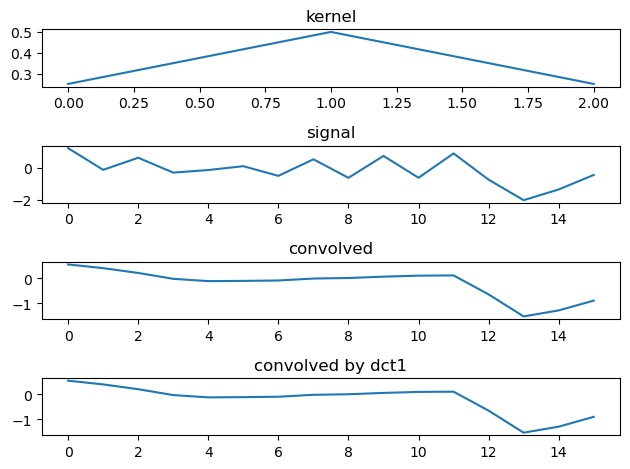

In [4]:
def convdct1(x, kernel):
    kernel = kernel[(len(kernel)-1)//2:]  # symmetric bit only
    kernel = ensure_shape(kernel, x.shape, side='post')
    return idct1(dct1(x) * dct1(kernel))


y = conv1d(x, k, bound='dct1')
z = convdct1(x, k)

print(y-z)

plt.subplot(4, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(4, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(4, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.subplot(4, 1, 4)
plt.plot(z)
plt.title('convolved by dct1')
plt.tight_layout()
plt.show()

In [9]:
def mydct1(x, forward=True):
    n = len(x)
    x = torch.cat([x, x[1:-1].flip(0)])
    x = torch.real(fft(x)[:n])
    if not forward: x /= 2*(n-1)
    return x


def myidct1(x):
    return mydct1(x, False)


def reshuffle_dct2(x, dst=True):
    return torch.cat((x[::2], x[1::2].flip(0) * (-1 if dst else 1)))


def mult_factor_dct2(n, norm_factor, **backend):
    real = torch.zeros(n, **backend)
    imag = torch.arange(n, **backend)
    imag *= -math.pi / (2 * n)
    out = torch.complex(real, imag).exp_().mul_(2 * norm_factor)
    return out


def exp_factor_dct2(x, norm_factor):
    return mult_factor_dct2(len(x), norm_factor, dtype=x.real.dtype, device=x.device)


def mydct2(x, dst=False, forward=True):
    n = len(x)
    x = reshuffle_dct2(x, dst)
    x = fft(x)
    x *= exp_factor_dct2(x, 1/(2*n) if not forward else 1)
    x = torch.real(x)
    return x


def myidct2(x):
    return mydct3(x, forward=False)


def mydct2_variant(x, dst=False, forward=True):
    n = len(x)
    y = x
    x = y.new_zeros([4*n])
    x[1:2*n:2] = y
    x[2*n+1::2] = y.flip(0)
    x = torch.real(fft(x)[:n])
    if not forward: x /= 2*n
    return x


def reshuffle_dct3(y, dst):
    n = len(y)
    x = torch.empty_like(y)
    n_half = (n + 1) // 2

    x[0::2] = y[:n_half]
    x[1::2] = y[n_half:].flip(0) * (-1 if dst else 1)
    return x


def mult_factor_dct3(n, norm_factor, **backend):
    real = torch.zeros(n, **backend)
    imag = torch.arange(n, **backend)
    imag *= math.pi / (2 * n)
    out = torch.complex(real, imag).exp_().mul_(2 * norm_factor * n)
    return out


def exp_factor_dct3(x, norm_factor):
    return mult_factor_dct3(len(x), norm_factor, dtype=x.dtype, device=x.device)


def mydct3(x, dst=False, forward=True):
    n = len(x)
    if dst: x = x.flip(0)
    x = x * exp_factor_dct3(x, 1/(2*n) if not forward else 1)
    x[0] *= 0.5
    x = torch.real(ifft(x))
    x = reshuffle_dct3(x, dst)
    return x


def myidct3(x):
    return mydct2(x, forward=False)

tensor([ 0.0278, -0.0313,  0.0188, -0.0154, -0.0004,  0.0020, -0.0079,  0.0102,
        -0.0106,  0.0118, -0.0166,  0.0433,  0.0113, -0.0607, -0.0090,  0.0267],
       dtype=torch.float64)


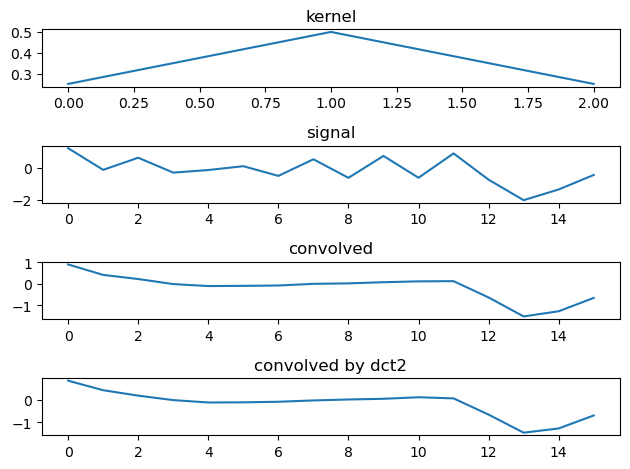

In [10]:
def convdct2(x, kernel):
    kernel = kernel[(len(kernel)-1)//2:]  # symmetric bit only
    kernel = ensure_shape(kernel, x.shape, side='post')
    return myidct2(mydct2(x) * mydct1(kernel))


x = x.double()
k = k.double()
y = conv1d(x, k, bound='dct2')
z = convdct2(x, k)

print(y-z)

plt.subplot(4, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(4, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(4, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.subplot(4, 1, 4)
plt.plot(z)
plt.title('convolved by dct2')
plt.tight_layout()
plt.show()

tensor([-0.0021,  0.0739,  0.0342,  0.0292, -0.0128,  0.0193, -0.0351, -0.0145,
         0.0036, -0.0232, -0.0206,  0.0085,  0.0372,  0.0032,  0.0328, -0.0514,
        -0.0146], dtype=torch.float64)


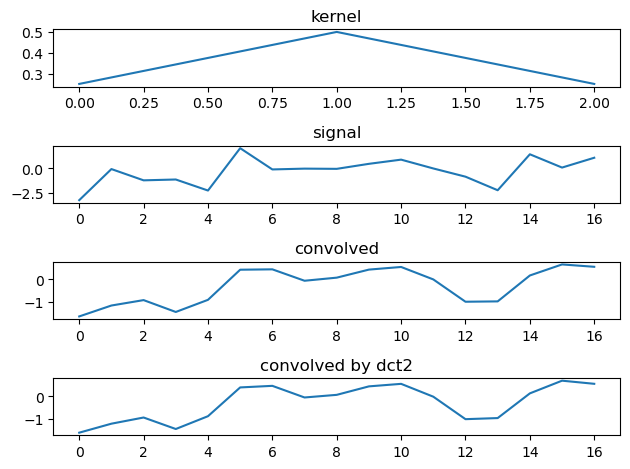

In [49]:
def convdst1(x, kernel):
    kernel = kernel[(len(kernel)-1)//2:]  # symmetric bit only
    kernel = ensure_shape(kernel, x.shape, side='post')
    return idst1(dst1(x) * dct1(kernel))


x = x.double()
k = k.double()
y = conv1d(x, k, bound='dst1')
z = convdst1(x, k)

print(y-z)

plt.subplot(4, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(4, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(4, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.subplot(4, 1, 4)
plt.plot(z)
plt.title('convolved by dst1')
plt.tight_layout()
plt.show()

tensor([ 0.0647,  0.0534,  0.0054,  0.0721,  0.0443, -0.0632, -0.0398,  0.0188,
         0.0057, -0.0254, -0.0450, -0.0141,  0.0671,  0.0688, -0.0282, -0.0566,
        -0.0204], dtype=torch.float64)


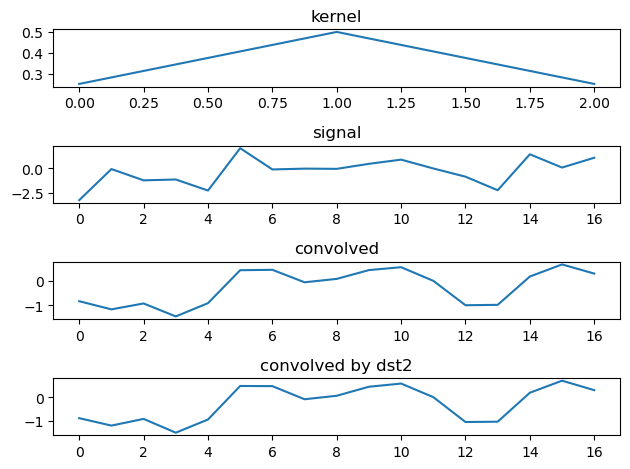

In [50]:
def convdst2(x, kernel):
    kernel = kernel[(len(kernel)-1)//2:]  # symmetric bit only
    kernel = ensure_shape(kernel, x.shape, side='post')
    return idst2(dst2(x) * dct1(kernel))


x = x.double()
k = k.double()
y = conv1d(x, k, bound='dst2')
z = convdst2(x, k)

print(y-z)

plt.subplot(4, 1, 1)
plt.plot(k)
plt.title('kernel')
plt.subplot(4, 1, 2)
plt.plot(x)
plt.title('signal')
plt.subplot(4, 1, 3)
plt.plot(y)
plt.title('convolved')
plt.subplot(4, 1, 4)
plt.plot(z)
plt.title('convolved by dst2')
plt.tight_layout()
plt.show()